# Colab Stuff
Pre-setup needed to be done for running the model on Google Colaboratory

In [0]:
!wget https://cdn.skillenza.com/files/5ee0a2e1-bf6d-4173-8244-e75fa2d7bbe2/training.5k.zip
!wget https://cdn.skillenza.com/files/7da538a3-4db6-46ea-a4f8-87a21368e5f5/testing.40k.zip
!wget https://cdn.skillenza.com/files/b8f97b6c-70a5-4f00-b748-9f9765c9b17e/sample.csv

--2019-01-06 16:30:03--  https://cdn.skillenza.com/files/5ee0a2e1-bf6d-4173-8244-e75fa2d7bbe2/training.5k.zip
Resolving cdn.skillenza.com (cdn.skillenza.com)... 99.84.59.14, 99.84.59.48, 99.84.59.66, ...
Connecting to cdn.skillenza.com (cdn.skillenza.com)|99.84.59.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137569412 (131M) [application/zip]
Saving to: ‘training.5k.zip’

training.5k.zip     100%[===================>] 131.20M  75.7MB/s    in 1.7s    

2019-01-06 16:30:05 (75.7 MB/s) - ‘training.5k.zip’ saved [137569412/137569412]

--2019-01-06 16:30:07--  https://cdn.skillenza.com/files/7da538a3-4db6-46ea-a4f8-87a21368e5f5/testing.40k.zip
Resolving cdn.skillenza.com (cdn.skillenza.com)... 99.84.59.14, 99.84.59.48, 99.84.59.66, ...
Connecting to cdn.skillenza.com (cdn.skillenza.com)|99.84.59.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1099209878 (1.0G) [application/zip]
Saving to: ‘testing.40k.zip’

testing.40k.zip     100

In [0]:
!unzip training.5k.zip
!mv training/training/* training/
!rm training/training -rf

# Import Stuff, Load and preprocess data

## Wide Residual Network
Open Source implementation of Wide Residual Networks (https://arxiv.org/abs/1605.07146) from https://github.com/EricAlcaide/keras-wrn

In [0]:
import keras
import keras.backend as K 
from keras.models import Model
from keras.layers import Dense, Dropout, Add, Input, BatchNormalization, Activation
from keras.layers import  Conv2D, MaxPooling2D, AveragePooling2D, Flatten
from keras.regularizers import l2

def main_block(x, filters, n, strides, dropout):
	# Normal part
	x_res = Conv2D(filters, (3,3), strides=strides, padding="same")(x)# , kernel_regularizer=l2(5e-4)
	x_res = BatchNormalization()(x_res)
	x_res = Activation('relu')(x_res)
	x_res = Conv2D(filters, (3,3), padding="same")(x_res)
	# Alternative branch
	x = Conv2D(filters, (1,1), strides=strides)(x)
	# Merge Branches
	x = Add()([x_res, x])

	for i in range(n-1):
		# Residual conection
		x_res = BatchNormalization()(x)
		x_res = Activation('relu')(x_res)
		x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		# Apply dropout if given
		if dropout: x_res = Dropout(dropout)(x)
		# Second part
		x_res = BatchNormalization()(x_res)
		x_res = Activation('relu')(x_res)
		x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		# Merge branches
		x = Add()([x, x_res])

	# Inter block part
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	return x

def build_model(input_dims, output_dim, n, k, act= "relu", dropout=None):
	""" Builds the model. Params:
			- n: number of layers. WRNs are of the form WRN-N-K
				 It must satisfy that (N-4)%6 = 0
			- k: Widening factor. WRNs are of the form WRN-N-K
				 It must satisfy that K%2 = 0
			- input_dims: input dimensions for the model
			- output_dim: output dimensions for the model
			- dropout: dropout rate - default=0 (not recomended >0.3)
			- act: activation function - default=relu. Build your custom
				   one with keras.backend (ex: swish, e-swish)
	"""
	# Ensure n & k are correct
	assert (n-4)%6 == 0
	assert k%2 == 0
	n = (n-4)//6 
	# This returns a tensor input to the model
	inputs = Input(shape=(input_dims))

	# Head of the model
	x = Conv2D(16, (3,3), padding="same")(inputs)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# 3 Blocks (normal-residual)
	x = main_block(x, 16*k, n, (1,1), dropout) # 0
	x = main_block(x, 32*k, n, (2,2), dropout) # 1
	x = main_block(x, 64*k, n, (2,2), dropout) # 2
			
	# Final part of the model
	x = AveragePooling2D((8,8))(x)
	x = Flatten()(x)
	outputs = Dense(output_dim, activation="softmax")(x)

	model = Model(inputs=inputs, outputs=outputs)
	return model

Using TensorFlow backend.


In [0]:
# 6, 22, 4 turn out to be optimum values for our model
model = build_model((200,200,1), 6, 22, 4)

# Compiling the model with adaptive learning rate algorithm, Adam
model.compile("adam", "categorical_crossentropy", ["accuracy"])

## Preprocessing

In [0]:
def preprocess1(img, ksize=2, denom=1, morphsize=(5, 6), sigma=1):
    """
    Performs 2D Convolution filtering + Morphological Opening
    to extract out the central blob in binary format,
    and to reduce the other noise.
    
    """
    assert denom > 0, 'denom should be greater than 0'
    assert ksize == int(ksize) & ksize > 0, 'ksize must be a positive integer.'

    kernel = np.ones((ksize, ksize), np.float32) / denom
    dst = cv2.filter2D(img, -1, kernel)
    dst = cv2.morphologyEx(dst, cv2.MORPH_OPEN, np.ones(morphsize, np.uint8))

    dst = color.rgb2gray(dst) < color.rgb2gray(dst).mean()
    
    dst = dst.astype(np.uint8)

    return dst


def crop_image(id, data='training',
                  ksize=2, denom=1, morphsize=(5, 6),
                  rgb=False):
    """
    Crops out only the central blob by:
    
    1. Running an edge detection filter with high central value
    and division factor to essentially turn the central blob to 
    solid black and white everywhere else.
    2. Using OpenCV contours to detect the contours in image and selecting
    the one with the largest area (which will be the central one)
    3. Cropping out the largest contour to get only the central blob,
    without any external noise.
    
    """
    img = io.imread(f'{data}/{id}.png')

    edged = preprocess1(img, ksize=3,
                       denom=10, morphsize=morphsize)
    
    (_, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
                                cv2.CHAIN_APPROX_SIMPLE)

    cnts_sorted = sorted(cnts, key=cv2.contourArea, reverse=True)
    x, y, w, h = cv2.boundingRect(cnts_sorted[0])
    cropped = img[y:y+h, x:x+w]
    
    if not rgb:
        cropped = preprocess1(cropped, ksize=ksize,
                       denom=denom, morphsize=morphsize)
    
    return cropped
def prepare_image(id, data='training', shape=(200, 200), rgb=False):
    img = crop_image(id,data, rgb=rgb)  
    img = cv2.resize(img, shape)
    return img

## Importing Modules and loading data

In [0]:
import numpy as np
from skimage import feature, io, color, morphology
import cv2
import matplotlib.pyplot as plt
import pandas as pd

from keras import Sequential
from keras.utils import to_categorical

In [0]:
X = np.empty((5000, 200, 200), dtype=np.uint8)
import math
for i in range(1,5001):
    step = 25 / 5001
    #X.append(cv2.resize(io.imread(f"training/training/{i}.png"),(224,224)))
#     X.append(cv2.resize(io.imread(f"training/{i}.png"), (200, 200)))
    
    X[i-1] = cv2.cvtColor(prepare_image(i, data='training', rgb=True, shape=(200, 200)), cv2.COLOR_RGB2GRAY)
    print('\r' + f'Progress: '
                f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
                f"({math.ceil((i+1) * 100 /5001)} %)",
                end='')

Progress: [=========================](100 %)

In [0]:
labels = pd.read_csv('training/solution.csv')
y = to_categorical(labels.category.values-1)

# Training the model

In [0]:
history = model.fit(
    X[..., None], y, epochs=40,
    validation_split=.15,
    callbacks=[keras.callbacks.ModelCheckpoint(
                  'Model.val-acc={val_acc:.2f}.val-loss={val_loss:.2f}.h5',
                  monitor='val_loss',
                  verbose=0,
                  save_best_only=True,
                  save_weights_only=False,
                  mode='auto',
                  period=1
      )]
)

Train on 4250 samples, validate on 750 samples
Epoch 1/40
4250/4250 [==============================] - 393s 92ms/step - loss: 1.6770 - acc: 0.2795 - val_loss: 1.5425 - val_acc: 0.3147
Epoch 2/40
4250/4250 [==============================] - 376s 88ms/step - loss: 1.4863 - acc: 0.3068 - val_loss: 1.9716 - val_acc: 0.2587
Epoch 3/40
4250/4250 [==============================] - 376s 89ms/step - loss: 1.4473 - acc: 0.3167 - val_loss: 1.9448 - val_acc: 0.2293
Epoch 4/40
4250/4250 [==============================] - 376s 89ms/step - loss: 1.4165 - acc: 0.3315 - val_loss: 1.4124 - val_acc: 0.3200
Epoch 5/40
4250/4250 [==============================] - 376s 89ms/step - loss: 1.3983 - acc: 0.3315 - val_loss: 1.4675 - val_acc: 0.3480
Epoch 6/40
4250/4250 [==============================] - 376s 89ms/step - loss: 1.3410 - acc: 0.3696 - val_loss: 3.5795 - val_acc: 0.2640
Epoch 7/40
4250/4250 [==============================] - 376s 89ms/step - loss: 1.2873 - acc: 0.4045 - val_loss: 1.5668 - val_acc: 0

# Analyzing

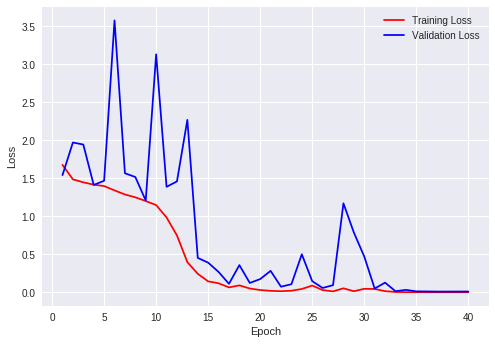

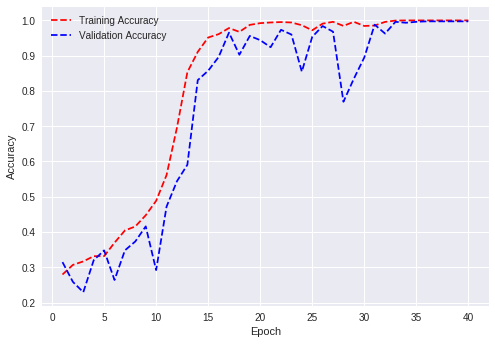

In [0]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']
training_acc = history.history['acc']
val_acc = history.history['val_acc']


# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r-')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b--')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Loading the best weights obtained from the training and predicting for the test data

In [0]:
from keras.models import load_model
model = load_model('Model.val-acc=1.00.val-loss=0.01.h5')

In [0]:
sample_sub = pd.read_csv('sample.csv')

import math
n = len(sample_sub.id)
step = 25 / n

for i, id in enumerate(sample_sub.id):
  sample_sub.category[sample_sub.id == id] = np.argmax(model.predict(
                      cv2.cvtColor(prepare_image(id, data='testing', rgb=True, shape=(200, 200)), cv2.COLOR_RGB2GRAY)[None, ..., None]
                        )) + 1
  print('\r' + f'Predict Progress: '
                f"[{'=' * int((i+1) * step) + ' ' * (24 - int((i+1) * step))}]"
                f"({math.ceil((i+1) * 100 /n)} %)",
                end='')

Predict Progress: [=========================](100 %)

In [0]:
sample_sub.to_csv('pred.csv', index=False)